# 데이터 분류 모델

## 타이타닉의 생존자 가려내기

### 탐색 : 타이타닉 데이터 살펴보기

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df_train = pd.read_csv('titanic_train.csv')
df_test = pd.read_csv('titanic_test.csv')

df_train.head()

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,body,home.dest
0,2,1,"Mellinger, Miss. Madeleine Violet",female,13.0,0,1,250644,19.5000,NaN,S,NaN,"England / Bennington, VT"
1,2,1,"Wells, Miss. Joan",female,4.0,1,1,29103,23.0000,NaN,S,NaN,"Cornwall / Akron, OH"
2,2,1,"Duran y More, Miss. Florentina",female,30.0,1,0,SC/PARIS 2148,13.8583,NaN,C,NaN,"Barcelona, Spain / Havana, Cuba"
3,3,0,"Scanlan, Mr. James",male,NaN,0,0,36209,7.7250,NaN,Q,NaN,NaN
4,3,1,"Bradley, Miss. Bridget Delia",female,22.0,0,0,334914,7.7250,NaN,Q,NaN,"Kingwilliamstown, Co Cork, Ireland Glens Falls..."


In [2]:
print(df_train.info())
print('--------------')
print(df_test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 916 entries, 0 to 915
Data columns (total 13 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   pclass     916 non-null    int64  
 1   survived   916 non-null    int64  
 2   name       916 non-null    object 
 3   sex        916 non-null    object 
 4   age        741 non-null    float64
 5   sibsp      916 non-null    int64  
 6   parch      916 non-null    int64  
 7   ticket     916 non-null    object 
 8   fare       916 non-null    float64
 9   cabin      214 non-null    object 
 10  embarked   914 non-null    object 
 11  body       85 non-null     float64
 12  home.dest  527 non-null    object 
dtypes: float64(3), int64(4), object(6)
memory usage: 93.2+ KB
None
--------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 393 entries, 0 to 392
Data columns (total 13 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   pclass     393 non-nul

In [4]:
# name, ticket, body, cabin, home.dest 피처 제거 
df_train = df_train.drop(['name', 'ticket', 'body', 'cabin', 'home.dest'], axis = 1)
df_test = df_test.drop(['name', 'ticket', 'body', 'cabin', 'home.dest'], axis = 1)

0    563
1    353
Name: survived, dtype: int64


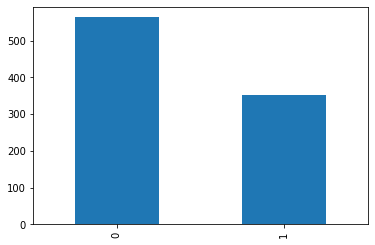

In [7]:
print(df_train['survived'].value_counts())
df_train['survived'].value_counts().plot.bar()
plt.show()

3    498
1    230
2    188
Name: pclass, dtype: int64


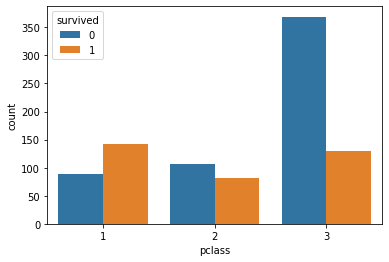

In [8]:
# survived 피처를 기준으로 그룹을 나누어 그룹별 pclass 피처의 분포를 살펴보자
print(df_train['pclass'].value_counts())
ax = sns.countplot(x = 'pclass', hue = 'survived', data = df_train)
plt.show()

In [12]:
# 변수 탐색 작업 자동화
from scipy import stats

def valid_features(df, col_name, distribution_check = True):
    # 두 집단의 분포 그래프 출력 
    g = sns.FacetGrid(df, col = 'survived')
    g.map(plt.hist, col_name, bins = 30)
    # 두 집단의 표준편차 출력 
    titanic_survived = df[df['survived'] == 1] # 생존자 
    titanic_survived_static = np.array(titanic_survived[col_name])
    print("data std is", '%2f' % np.std(titanic_survived_static))
    titanic_n_survived = df[df['survived'] == 0] # 생존자x
    titanic_n_survived_static = np.array(titanic_n_survived[col_name])
    print("data std is", '%2f' % np.std(titanic_n_survived_static))
    # T-test로 두 집단의 평균 차이를 검정 
    tTestResult = stats.ttest_ind(titanic_survived[col_name], titanic_n_survived[col_name])
    tTestResultDiffVar = stats.ttest_ind(titanic_survived[col_name], titanic_n_survived[col_name], equal_var = False)
    print('The t-statistic and p-value assuming equal variances is %.3f and %.3f.' % tTestResult)
    print('The t-statistic and p-value not assuming equal variances is %.3f and %.3f.' % tTestResultDiffVar)
    
    if distribution_check:
        print('The w-statistic and p-value in Survived %.3f and %.3f' % stats.shapiro(titanic_survived[col_name]))
        print('The w-statistic and p-value in Non-Survived %.3f and %.3f' % stats.shapiro(titanic_n_survived[col_name]))

data std is 14.217911
data std is 13.710057
The t-statistic and p-value assuming equal variances is -0.546 and 0.585.
The t-statistic and p-value not assuming equal variances is -0.543 and 0.587.
The w-statistic and p-value in Survived 0.982 and 0.001
The w-statistic and p-value in Non-Survived 0.968 and 0.000
data std is 0.644624
data std is 1.337840
The t-statistic and p-value assuming equal variances is -2.118 and 0.034.
The t-statistic and p-value not assuming equal variances is -2.446 and 0.015.


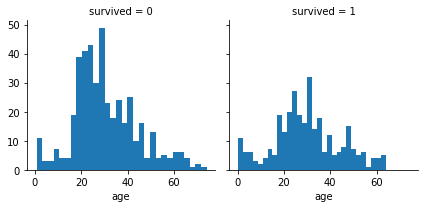

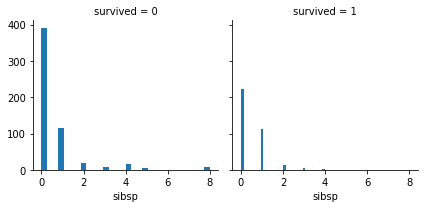

In [13]:
valid_features(df_train[df_train['age'] > 0], 'age', distribution_check = True)
valid_features(df_train, 'sibsp', distribution_check = False)

### 분류 : 생존자 분류 모델 만들기

In [18]:
# 분류 모델을 위한 데이터 전처리 하기 
# age의 결측값을 평균으로 대체 
replace_mean = df_train[df_train['age'] > 0]['age'].mean()
df_train['age'] = df_train['age'].fillna(replace_mean)
df_test['age'] = df_test['age'].fillna(replace_mean)
# embark : 2개의 결측값을 최빈값으로 대체 
embarked_mode = df_train['embarked'].value_counts().index[0]
df_train['embarked'] = df_train['embarked'].fillna(embarked_mode)
df_test['embarked'] = df_test['embarked'].fillna(embarked_mode)
# 원-핫 인코딩을 위한 통합 데이터 생성
whole_df = df_train.append(df_test)
train_idx_num = len(df_train)
# pandas 패키지를 이용한 원-핫 인코딩
whole_df_encoded = pd.get_dummies(whole_df)
df_train = whole_df_encoded[:train_idx_num]
df_test = whole_df_encoded[train_idx_num:]

df_train.head()

/var/folders/h8/lf5m26_x4xjf5dmtlv4y4t440000gn/T/ipykernel_41312/1367362776.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  whole_df = df_train.append(df_test)


,pclass,survived,age,sibsp,parch,fare,sex_female,sex_male,embarked_C,embarked_Q,embarked_S
0,2,1,13.000000,0,1,19.5000,1,0,0,0,1
1,2,1,4.000000,1,1,23.0000,1,0,0,0,1
2,2,1,30.000000,1,0,13.8583,1,0,1,0,0
3,3,0,30.231444,0,0,7.7250,0,1,0,1,0
4,3,1,22.000000,0,0,7.7250,1,0,0,1,0


#### 로지스틱 회귀 모델

In [19]:
# 로지스틱 회귀 모델 
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [22]:
x_train, y_train = df_train.loc[:, df_train.columns != 'survived'].values, df_train['survived'].values
x_test, y_test = df_test.loc[:, df_test.columns != 'survived'].values, df_test['survived'].values

lr = LogisticRegression(random_state = 0)
lr.fit(x_train, y_train)

y_pred = lr.predict(x_test)
y_pred_probability = lr.predict_proba(x_test)[:, 1]

/opt/homebrew/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [24]:
print('accuracy : %.2f' % accuracy_score(y_test, y_pred))
print('Precision : %.3f' % precision_score(y_test, y_pred))
print('Recall : %.3f' % recall_score(y_test, y_pred))
print('F1 : %.3f' % f1_score(y_test, y_pred))

accuracy : 0.80
Precision : 0.756
Recall : 0.673
F1 : 0.712


In [25]:
# confusion matrix
from sklearn.metrics import confusion_matrix

confmat = confusion_matrix(y_true = y_test, y_pred = y_pred)
print(confmat)

[[214  32]
 [ 48  99]]


AUC : 0.838


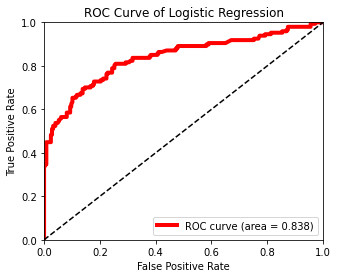

In [27]:
# 로지스틱 회귀 모델의 AUC 구하기 
from sklearn.metrics import roc_curve, roc_auc_score

false_positive_rate, true_positive_rate, threshold = roc_curve(y_test, y_pred_probability)
roc_auc = roc_auc_score(y_test, y_pred_probability)
print('AUC : %.3f' % roc_auc)

# ROC 그래프 출력 
plt.rcParams['figure.figsize'] = [5, 4]
plt.plot(false_positive_rate, true_positive_rate, label = 'ROC curve (area = %0.3f)' % roc_auc, color = 'red', linewidth = 4.0)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve of Logistic Regression')
plt.legend(loc = 'lower right')
plt.show()

#### 의사결정트리 모델

accuracy : 0.74
Precision : 0.667
Recall : 0.626
F1 : 0.646
AUC : 0.733


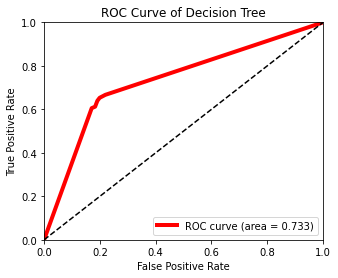

In [28]:
from sklearn.tree import DecisionTreeClassifier

dtc = DecisionTreeClassifier()
dtc.fit(x_train, y_train)
y_pred = dtc.predict(x_test)
y_pred_probability = dtc.predict_proba(x_test)[:, 1]

# 학습한 모델의 성능을 계산 
print('accuracy : %.2f' % accuracy_score(y_test, y_pred))
print('Precision : %.3f' % precision_score(y_test, y_pred))
print('Recall : %.3f' % recall_score(y_test, y_pred))
print('F1 : %.3f' % f1_score(y_test, y_pred))


false_positive_rate, true_positive_rate, threshold = roc_curve(y_test, y_pred_probability)
roc_auc = roc_auc_score(y_test, y_pred_probability)
print('AUC : %.3f' % roc_auc)

# ROC 그래프 출력 
plt.rcParams['figure.figsize'] = [5, 4]
plt.plot(false_positive_rate, true_positive_rate, label = 'ROC curve (area = %0.3f)' % roc_auc, color = 'red', linewidth = 4.0)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve of Decision Tree')
plt.legend(loc = 'lower right')
plt.show()